In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:

def make_datasets(n_obs=10, degree=2, clusters=3, T=15, n_samples=100, repetitions=False):
    clusters_reps = [nx.random_regular_graph(d=degree, n=n_obs) for i in range(clusters)]
    adjacencies = []
    for i in range(clusters):
        A = nx.adjacency_matrix(clusters_reps[i]).todense().astype(float)
        A[np.where(A!=0)]= np.random.rand(np.where(A!=0)[0].size)*0.45
        np.fill_diagonal(A, 1)
        adjacencies.append(A)
    
    pos = np.arange(0, T, T//(clusters+1))
    pos = np.sort(pos)
    pos = list(pos)+[T-1]
    
    thetas = []
    for i in range(len(pos)-1):
        how_many = int(pos[i+1]) - int(pos[i])-1
        new_list = [adjacencies[i%clusters]]
        target = adjacencies[(i+1)%clusters]

        for i in range(how_many):

            new = new_list[-1].copy()
            diffs = (new!=0).astype(int)-(target!=0).astype(int)
            diff = np.where(diffs!=0)
            if diff == ():
                break
            if(i==0):
                edges_per_change = int((np.nonzero(diffs)[0].shape[0]/2)//(how_many+1))
                if edges_per_change ==0:
                    edges_per_change+=1
            ixs = np.arange(diff[0].shape[0])
            np.random.shuffle(ixs)

            xs = diff[0][ixs[:edges_per_change]]
            ys = diff[1][ixs[:edges_per_change]]
            for j in range(xs.shape[0]):
                if diffs[xs[j], ys[j]] == -1:
                    new[xs[j], ys[j]] = np.random.rand(1)*0.2
                    new[ ys[j], xs[j]]=  new[xs[j], ys[j]]
                else:
                    new[xs[j], ys[j]] = 0
                    new[ ys[j], xs[j]]=0
            new_list.append(new)

        thetas += new_list
    thetas.append(target)
    covs = [np.linalg.inv(t) for t in thetas]
    samples = [np.random.multivariate_normal(np.zeros(n_obs), c, size=n_samples) for c in covs]
    return thetas, samples, covs, clusters_reps, pos

In [7]:
pos

[0, 3, 6, 9, 12, 14]

/home/vero/miniconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: covariance is not positive-semidefinite.


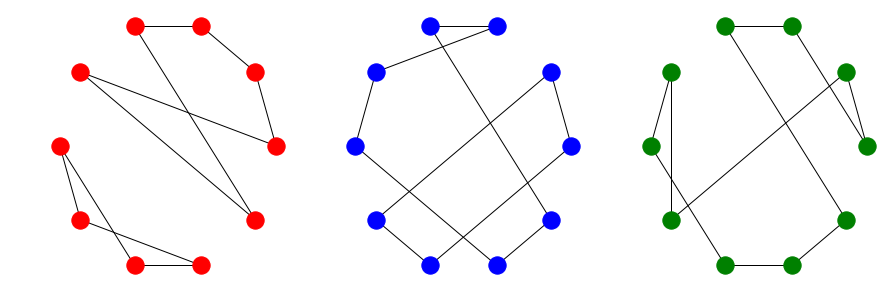

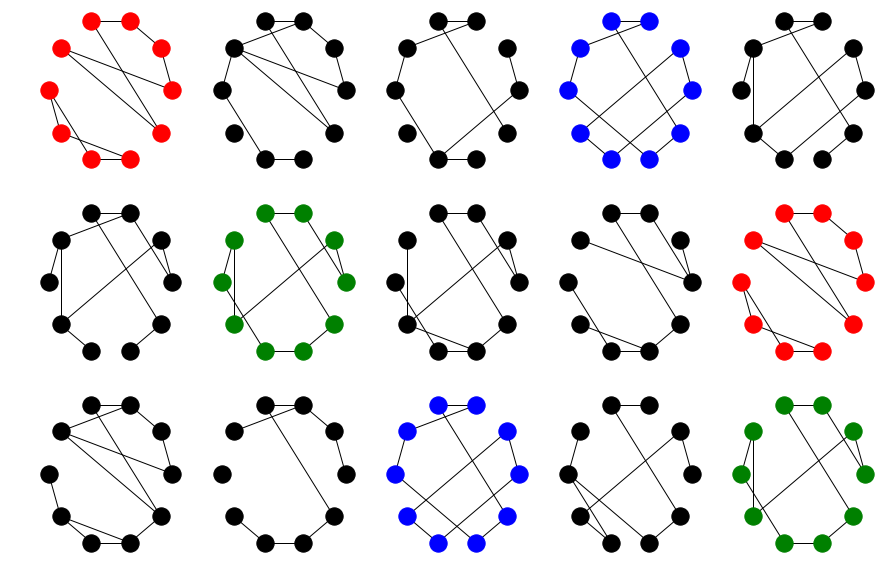

In [22]:
thetas, samples, covs, clusters_reps, pos= make_datasets(n_obs=10, degree=2, clusters=3, T=15, repetitions=False)


colors = ['red', 'blue', 'green', 'red', 'blue', 'green']
for i in range(3):
    nx.draw_circular(clusters_reps[i], ax=axs[i], node_color=colors[i] )
plt.savefig("../../../../Dropbox (DIBRIS)/PhD/PhD thesis/Images/temporal-models/cluster-representatives.pdf",
            transparent=True, dpi=200, bbox_inches='tight')
plt.show()

fig, axs = plt.subplots(3,5, figsize=(15,10))
k = 0
for i in range(3):
    for j in range(5):
        if k == 14:
            c = 'green'
        elif k in pos:
            c = colors[k//3]
        else:
            c = 'black'
        g = nx.from_numpy_array(thetas[k])
        nx.draw_circular(g, ax=axs[i, j], node_color=c)
        axs[i,j].set_facecolor(c)
        k+=1
plt.savefig("../../../../Dropbox (DIBRIS)/PhD/PhD thesis/Images/temporal-models/cluster-evolution.pdf",
            transparent=True, dpi=200, bbox_inches='tight')

plt.show()

In [ ]:
from regain.norm import l1_norm
distances = np.zeros((15,15))
for i, t in enumerate(thetas):
    for j, t1 in enumerate(thetas):
        distances[i,j] = l1_norm(t-t1)

distances /= np.max(distances)

sns.clustermap(1-distances)

In [ ]:
X = samples[0]
y = np.zeros(samples[0].shape[0])
for i, s in enumerate(samples[1:]):
    X = np.vstack((X, s))
    y = np.hstack((y, np.ones(s.shape[0])*(i+1)))

In [ ]:
from importlib import reload
import regain.clustering; reload(regain.clustering)
import regain.covariance.kernel_time_graphical_lasso_; reload(regain.covariance.kernel_time_graphical_lasso_)
from regain.covariance.kernel_time_graphical_lasso_ import SimilarityTimeGraphicalLasso

In [ ]:
stgl = SimilarityTimeGraphicalLasso(alpha=15, psi='l1', verbose=1)
stgl.fit(X, y)

In [ ]:
import seaborn as sns
sns.clustermap(stgl.similarity_matrix)

In [ ]:
from regain.utils import structure_error
structure_error(np.array(thetas), stgl.precision_)